In [74]:
import pandas as pd
from prophet import Prophet

from pandas_datareader import data as pdr
import yfinance as yfin

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import mlflow

yfin.pdr_override()

In [75]:
MLFLOW_IP = os.environ['MLFLOW_IP']
MLFLOW_PASSWORD = os.environ['MLFLOW_PASSWORD']
MLFLOW_USER = os.environ['MLFLOW_USER']
MLFLOW_PORT = os.environ['MLFLOW_PORT']

In [76]:
ticker_name = '^GSPC'

In [77]:
test_df = pdr.get_data_yahoo(ticker_name, start='2022-11-16', end='2023-01-04')

[*********************100%***********************]  1 of 1 completed


In [78]:
ticker = pdr.get_data_yahoo(ticker_name, start='2021-08-01', end='2022-11-15')

[*********************100%***********************]  1 of 1 completed


In [79]:
ticker

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-08-02 00:00:00-04:00,4406.859863,4422.180176,4384.810059,4387.160156,4387.160156,3724090000
2021-08-03 00:00:00-04:00,4392.740234,4423.790039,4373.000000,4423.149902,4423.149902,3965190000
2021-08-04 00:00:00-04:00,4415.950195,4416.169922,4400.229980,4402.660156,4402.660156,4260760000
2021-08-05 00:00:00-04:00,4408.859863,4429.759766,4408.859863,4429.100098,4429.100098,3769410000
2021-08-06 00:00:00-04:00,4429.069824,4440.819824,4429.069824,4436.520020,4436.520020,3451870000
...,...,...,...,...,...,...
2022-11-08 00:00:00-05:00,3817.020020,3859.399902,3786.280029,3828.110107,3828.110107,4607640000
2022-11-09 00:00:00-05:00,3810.939941,3818.199951,3744.219971,3748.570068,3748.570068,4645010000
2022-11-10 00:00:00-05:00,3859.889893,3958.330078,3859.889893,3956.370117,3956.370117,5781260000


In [80]:
df = ticker[['Close']].copy()

In [81]:
df.reset_index(inplace=True)

In [82]:
df.rename({'Date': 'ds', 'Close': 'y'}, axis=1, inplace=True)

In [83]:
df

,ds,y
0,2021-08-02 00:00:00-04:00,4387.160156
1,2021-08-03 00:00:00-04:00,4423.149902
2,2021-08-04 00:00:00-04:00,4402.660156
3,2021-08-05 00:00:00-04:00,4429.100098
4,2021-08-06 00:00:00-04:00,4436.520020
...,...,...
321,2022-11-08 00:00:00-05:00,3828.110107
322,2022-11-09 00:00:00-05:00,3748.570068
323,2022-11-10 00:00:00-05:00,3956.370117
324,2022-11-11 00:00:00-05:00,3992.929932


In [84]:
df['ds'] = df['ds'].dt.tz_localize(None)

In [85]:
mlflow.set_tracking_uri('http://{}:{}'.format(MLFLOW_IP, MLFLOW_PORT))

In [60]:
exp_id = mlflow.create_experiment(
    name='Prophet',
    artifact_location="sftp://{}:{}@{}:/home/godder/mlflow_storage/artifacts".format(MLFLOW_USER, MLFLOW_PASSWORD, MLFLOW_IP),
    tags={'ticker':'^GSPC'}
)

In [86]:
exp_id = mlflow.get_experiment_by_name('Prophet').experiment_id

mlflow.set_experiment(experiment_id=exp_id)
print('done')

done


In [87]:
mlflow.start_run(experiment_id=exp_id, run_name='Prophet training')

<ActiveRun: >

In [88]:
mlflow.set_tag('ticker', '^GSPC')

In [89]:
mlflow.log_param('changepoint_range', 1)
mlflow.log_param('changepoint_prior_scale', 0.25)
mlflow.log_param('weekly_seasonality', False)

m = Prophet(changepoint_range=1, changepoint_prior_scale=0.25, weekly_seasonality=False)
m.fit(df)

02:40:26 - cmdstanpy - INFO - Chain [1] start processing
02:40:26 - cmdstanpy - INFO - Chain [1] done processing


In [90]:
days=45

In [91]:
future = m.make_future_dataframe(periods=days)
future['day'] = future['ds'].dt.weekday
future = future[future['day']<=4]

In [92]:
forecast = m.predict(future)

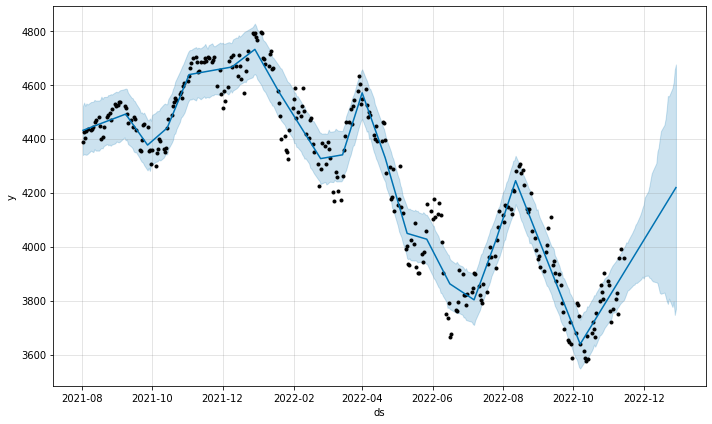

In [93]:
fig1 = m.plot(forecast)

In [94]:
fig1.axes[0].plot(test_df.index, test_df[['Close']].values, color='g')

In [96]:
mlflow.log_figure(fig1, 'test_plot.png')

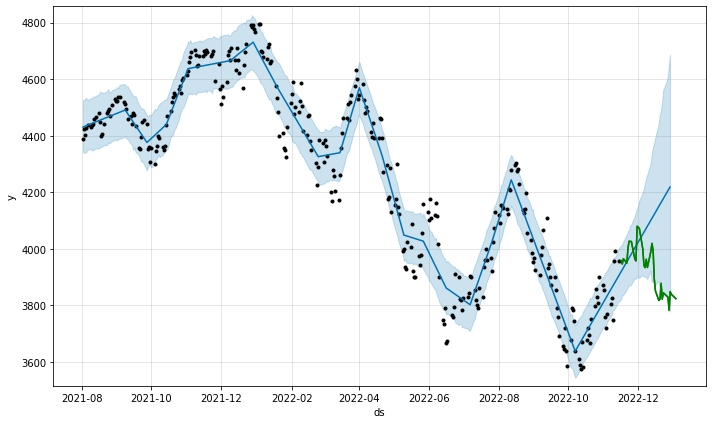

In [44]:
fig1

In [97]:
print('MSE', mean_squared_error(test_df['Close'], forecast[forecast['ds'] >= '2022-11-16']['yhat']))
print('MAPE', mean_absolute_percentage_error(test_df['Close'], forecast[forecast['ds'] >= '2022-11-16']['yhat']))
print('MAE', mean_absolute_error(test_df['Close'], forecast[forecast['ds'] >= '2022-11-16']['yhat']))

MSE 45123.32545938866
MAPE 0.042239958478016884
MAE 163.48678081205296


In [98]:
mae_test = mean_absolute_error(test_df['Close'], forecast[forecast['ds'] >= '2022-11-16']['yhat'])
mape_test = mean_absolute_percentage_error(test_df['Close'], forecast[forecast['ds'] >= '2022-11-16']['yhat'])
mse_test = mean_squared_error(test_df['Close'], forecast[forecast['ds'] >= '2022-11-16']['yhat'])

mlflow.log_metric('MAE/test', mae_test)
mlflow.log_metric('MAPE/test', mape_test)
mlflow.log_metric('MSE/test', mse_test)

In [99]:
mlflow.prophet.log_model(m,
                         'prophet',
                         registered_model_name='Prophet')

Registered model 'Prophet' already exists. Creating a new version of this model...
2023/01/18 02:43:01 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: Prophet, version 2
Created version '2' of model 'Prophet'.


In [100]:
mlflow.end_run()

# Fetching and testing

In [68]:
model = mlflow.pyfunc.load_model(
    model_uri=f"models:/Prophet/1"
)

/home/godder/.local/lib/python3.8/site-packages/prophet/serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


In [70]:
preds = model.predict(future)

done checking... changing stage to "Staging"

In [102]:
tracking_uri = mlflow.get_tracking_uri()
registry_uri = mlflow.get_registry_uri()

client = mlflow.MlflowClient(tracking_uri=tracking_uri, registry_uri=registry_uri)
client.transition_model_version_stage(
    name="Prophet",
    version=2,
    stage="Archived"
)
print('done')

done
